# Self-Attention Mechanism

Prevously, we have implemented a [Simple Attention Mechanism without Trainable Weights](https://github.com/nikitaprasad21/LLM-Cheat-Code/blob/main/Attention-Mechanism/Simplified_Attention_Mechanism.ipynb).

Let's improve our model and add some trainable weights:

## Self-Attention Class with Trainable Weights

In this repository, we're implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs.




> Note: This self-attention mechanism is also called "Scaled Dot-Product Attention".




Here’s the overall idea (similar to before):

* Computing context vectors as weighted sums over the input vectors, specific to a certain input element.

* For this, you need attention weights (normalized attention scores that sum up to 1, using the softmax function).

Here’s the modified architecture: 👇🏻







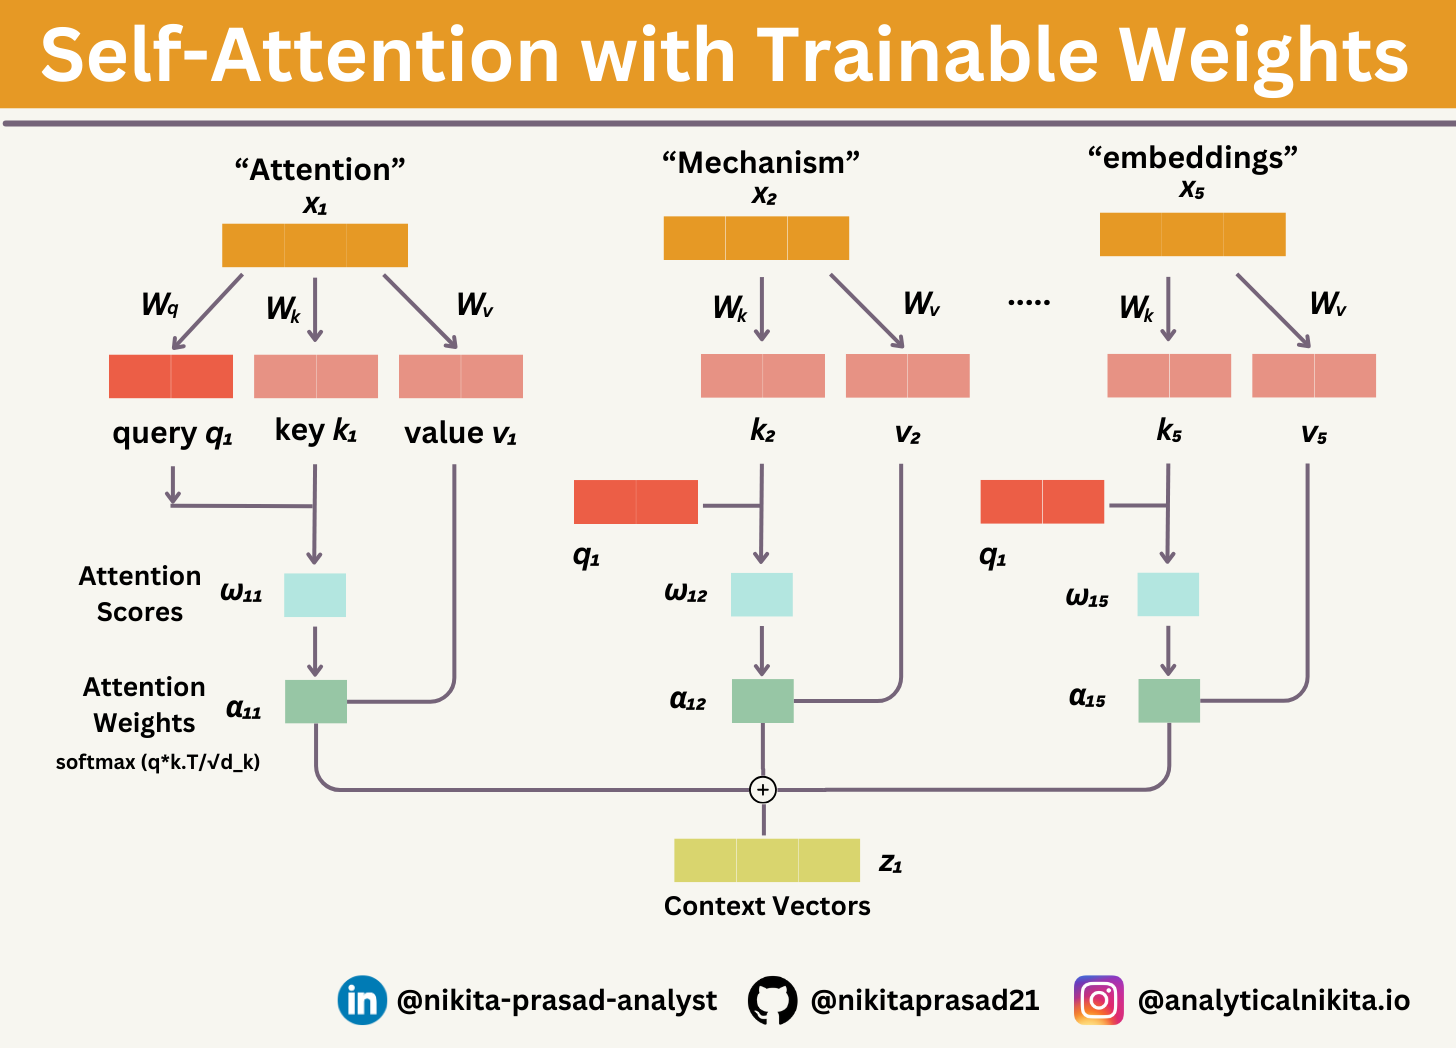

As you can see, there are only slight differences compared to the basic attention mechanism introduced earlier:

* The most notable difference is the introduction of weight matrices that are updated during model training

  * These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "reliable" context vectors.

* Also, now we scale the attention scores by dividing them by the square root of the embedding dimension, √dk (i.e., d_k**0.5):


So, let's understand:

## Why Divide by √dk (i.e., d_k**0.5):

<div class="alert alert-block alert-warning">

**Reason 1**: **For stability in learning**

The softmax function is sensitive to the magnitudes of its inputs. When the inputs are large, the differences between the exponential values of each input become much more pronounced.

This causes the softmax output to become "peaky," where the highest value receives almost all the probability mass, and the rest receive very little.

In attention mechanisms, particularly in transformers, if the dot products between query and key vectors become too large (like multiplying by 8 in this example), the attention scores can become very large.

This results in a very sharp softmax distribution, making the model overly confident in one particular "key." Such sharp distributions can make learning unstable,
    
</div>

In [ ]:
import torch

In [ ]:
# Define the tensor
tensor = torch.tensor([0.12, -0.24, 0.36, -0.82, 0.45])

# Apply softmax without scaling
softmax_result = torch.softmax(tensor, dim=-1)
print("Softmax without scaling:", softmax_result)

# Multiply the tensor by 8 and then apply softmax
scaled_tensor = tensor * 8
softmax_scaled_result = torch.softmax(scaled_tensor, dim=-1)
print("Softmax after scaling (tensor * 8):", softmax_scaled_result)

Softmax without scaling: tensor([0.2105, 0.1469, 0.2676, 0.0822, 0.2928])
Softmax after scaling (tensor * 8): tensor([4.5681e-02, 2.5643e-03, 3.1159e-01, 2.4765e-05, 6.4014e-01])


## But Why SQRT?

<div class="alert alert-block alert-warning">

**Reason 2**: To make the variance of the dot product stable

The dot product of Q and K increases the variance because multiplying two random numbers increases the variance.

The increase in variance grows with the dimension.

Dividing by sqrt (dimension) keeps the variance close to 1.
    
</div>

In [ ]:
import numpy as np

# Function to compute variance before and after scaling
def compute_variance(dim, num_trials=1000):
    dot_products = []
    scaled_dot_products = []

    # Generate multiple random vectors and compute dot products
    for _ in range(num_trials):
        q = np.random.randn(dim)
        k = np.random.randn(dim)

        # Compute dot product
        dot_product = np.dot(q, k)
        dot_products.append(dot_product)

        # Scale the dot product by sqrt(dim)
        scaled_dot_product = dot_product / np.sqrt(dim)
        scaled_dot_products.append(scaled_dot_product)

    # Calculate variance of the dot products
    variance_before_scaling = np.var(dot_products)
    variance_after_scaling = np.var(scaled_dot_products)

    return variance_before_scaling, variance_after_scaling

# For dimension 10
variance_before_10, variance_after_10 = compute_variance(10)
print(f"Variance before scaling (dim=10): {variance_before_10}")
print(f"Variance after scaling (dim=10): {variance_after_10}")
print("-"*50)

# For dimension 100
variance_before_100, variance_after_100 = compute_variance(100)
print(f"Variance before scaling (dim=100): {variance_before_100}")
print(f"Variance after scaling (dim=100): {variance_after_100}")
print("-"*50)

# For dimension 1000
variance_before_1000, variance_after_1000 = compute_variance(1000)
print(f"Variance before scaling (dim=1000): {variance_before_1000}")
print(f"Variance after scaling (dim=1000): {variance_after_1000}")

Variance before scaling (dim=10): 9.480982442157709
Variance after scaling (dim=10): 0.9480982442157707
--------------------------------------------------
Variance before scaling (dim=100): 97.1981130987418
Variance after scaling (dim=100): 0.971981130987418
--------------------------------------------------
Variance before scaling (dim=1000): 918.3696100866862
Variance after scaling (dim=1000): 0.9183696100866864


Now that this is clear to you, let's compute the context vector as a weighted sum over the value vectors.

Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector.

We can use matrix multiplication to obtain the output in one step:

## Implementing the Self-Attention Mechanism
We will start by introducing the three training weight matrices Wq, Wk, and Wv.

These three matrices are used to project the embedded input tokens, xi, into query, key, and value vectors via matrix multiplication:

* Query vector: **qi=Wqxi**

* Key vector: **ki=Wkxi**

* Value vector: **vi = Wvxi**

The embedding dimensions of the input `x` and the query vector `q` can be the same or different, depending on the model's design and specific implementation.



In [ ]:
input_emb = torch.tensor([
    [0.12, 0.45, 0.67],  # "Attention"
    [0.34, 0.56, 0.78],  # "Mechanism"
    [0.23, 0.57, 0.91],  # "drives"
    [0.76, 0.88, 0.45],  # "contextual"
    [0.54, 0.12, 0.34]   # "embedding"
], dtype=torch.float32)

Let's begin by defining a few variables:

A. The input embedding size, `d = 3`

B. The output embedding size, `d_out = 2`

In [ ]:
d_in = input_emb.shape[1] # the input embedding size, d=3
d_out = 2                 # the output embedding size, d=2

**Note**: In GPT models, the input and output dimensions are usually the same.

But for illustration purposes, to better follow the computation, we choose different input and output dimensions here:

In [ ]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        # Initialize the three weight matrices Wq, Wk and Wv
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        # Computing the query, key, and value vectors
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax( # aplha
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values # z
        return context_vec

In this PyTorch code, `SelfAttention_v1` is a class derived from `nn.Module`, which is a fundamental building block of PyTorch models, which provides necessary functionalities for model layer creation and management.

The init method initializes trainable weight matrices `(W_query, W_key, and W_value)` for queries, keys, and values, each transforming the input dimension `d_in` to an output dimension `d_out`.

During the forward pass, using the forward method, we compute the attention scores (attn_scores) by multiplying queries and keys, normalizing these scores using softmax.

Finally, we create a context vector by weighting the values with these normalized attention scores.

In [ ]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(input_emb))

tensor([[0.2818, 0.8398],
        [0.2855, 0.8487],
        [0.2861, 0.8502],
        [0.2878, 0.8542],
        [0.2782, 0.8311]], grad_fn=<MmBackward0>)


We can streamline the implementation above using **PyTorch's Linear Layers**, which are equivalent to a matrix multiplication if we disable the bias units.

Also, using `nn.Linear` over our manual `nn.Parameter(torch.rand(...)` approach is that `nn.Linear` has a preferred weight initialization scheme, which leads to more stable model training.

In [ ]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(input_emb))

tensor([[-0.5128, -0.0366],
        [-0.5141, -0.0376],
        [-0.5143, -0.0377],
        [-0.5143, -0.0377],
        [-0.5129, -0.0367]], grad_fn=<MmBackward0>)


**Note**: `SelfAttention_v1` and `SelfAttention_v2` give different outputs because they use different initial weights for the weight matrices

Bravo! You have successfully implemented a self-attention mechanism.

However, we’ve just scraped the tip of the iceberg.



> Stay Tuned, for Causual Self-Attention Implemmentation. You can star this repo and share with others.

